In [1]:
# It's dangerous to go alone, take these
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ranksums
from scipy.stats import mode, wilcoxon, ranksums, spearmanr, pearsonr
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from os import listdir

%matplotlib inline

#clustlist = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
clustlist = ['GSEA', 'GSVA','ORA','MetaNeighbor','Adobo','scCATCH','CIBERSORT']
clustnames = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
celllist =  ['LAmbDA',
             'Cell_BLAST',
             'RF',
             'kNN9',
             'ACTINN',
             'LDA',
             'LDArej',
             'CaSTLe',
             'scmapcluster',
             'SVM',
             'SingleCellNet',
             'scVI',
             'SVMrej',
             'scmapcell',
             'NMC',
             'singleR',
             'scID',
             'scPred',
             'CHETAH',
            ]

alg_rename = {key:item for key,item in zip(clustnames+celllist,clustlist+celllist)}
print(alg_rename)
dataset_rename = {'cb':'Breast',
                  'dg': 'Glioblastoma',
                  'jam': 'Melanoma',
                  'li_crc': 'Colorectal',
                  'llc': 'Lung',
                  'peng': 'Pancreatic',
                  'tm':'Metastatic Melanoma',
                  'vg':'AML',
                 }

def make_heatmap(infile, outfile, title, column, show_data=False):
    #read the result and set the index.
    result = pd.read_csv(infile, sep='\t')
    result
    hbs = result.reset_index()
    hbs.drop('index',axis=1, inplace=True)
    hbs.dataset = hbs.apply(lambda row: dataset_rename[row['dataset']], axis=1)
    hbs.algorithm = hbs.apply(lambda row: alg_rename[row['algorithm']], axis=1)
    
    #display the file if you want to make sure that it's loaded correctly
    if show_data:
        display(hbs)
    
    datasets = list(set(hbs.dataset))
    datasets = ['Colorectal', 'Breast', 'Glioblastoma','Metastatic Melanoma','Melanoma','AML','Lung','Pancreatic']
    methods = list(set(hbs.algorithm))
    # Make a dataframe of average f-measure for datasets and methods
    hmdf = pd.DataFrame(columns=datasets)
    for method in methods:
        #select only the rows for the current method and add them to the heatmap dataframe
        tempdf = hbs[hbs.algorithm == method].copy()
        datalist = []
        for dataset in datasets:
            datalist.append(tempdf[tempdf.dataset==dataset][column].mean())
        dataseries = pd.Series(datalist, index = hmdf.columns)
        hmdf = hmdf.append(dataseries,ignore_index=True)
    
    hmdf.index = methods
    
    #make a column of average values, sort by  that column, then save it in another variable and remove it.
    #hmdf['avg'] = hmdf.apply(lambda row: row.mean(), axis=1)
    hmdf['avg'] = hmdf.apply(lambda row: row.median(), axis=1) #MEDIAN INSTEAD OF MEAN
    if column == "VI":
        hmdf.sort_values(by='avg',ascending=True, inplace=True)
        colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=True, as_cmap=True)
    else:
        # sort by average and define a colourmap
        hmdf.sort_values(by='avg',ascending=False, inplace=True)
        colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
        colour = sns.color_palette("Greens",as_cmap=True)
    avg_hm = hmdf[['avg']].copy()
    hmdf=hmdf[datasets]
    
    fig, (ax1, ax2) = plt.subplots(1,2,dpi=100,gridspec_kw={'width_ratios': [1, 10]})
    
    # Old blue colour, might end up using green for the barplots
    # create heatmaps, rightplot is all the datasets, leftplot is the avg bar
    if column == "VI":
        rightplot = sns.heatmap(hmdf, vmin=0, vmax=4, annot=True, cmap=colour, ax=ax2, yticklabels=False)
        leftplot = sns.heatmap(avg_hm, vmin=0, vmax=4, annot=True, cmap=colour, ax=ax1, cbar=False, yticklabels=True)
    else:
        rightplot = sns.heatmap(hmdf, vmin=0, vmax=1, annot=True, cmap=colour, ax=ax2, yticklabels=False)
        leftplot = sns.heatmap(avg_hm, vmin=0, vmax=1, annot=True, cmap=colour, ax=ax1, cbar=False, yticklabels=True)
    rightplot.set_facecolor('silver')
    leftplot.set_facecolor('silver')
    rightplot.set_xticklabels(rightplot.get_xticklabels(),
                              rotation=45,
                              horizontalalignment='right')
    #leftplot.set_xticklabels(['Average'],
    leftplot.set_xticklabels(['Median'],
                             rotation=45,
                             horizontalalignment='right')
    fig.set_figheight(10)
    fig.set_figwidth(8)
    for i in leftplot.get_yticklabels():
        if i.get_text() in clustlist:
            i.set_color('brown')
    plt.gca().set_title(title)
    plt.savefig(outfile, bbox_inches = 'tight', dpi=500)

{'gsea': 'GSEA', 'gsva': 'GSVA', 'ora': 'ORA', 'metaneighbor': 'MetaNeighbor', 'adobo': 'Adobo', 'sccatch': 'scCATCH', 'cibersort': 'CIBERSORT', 'LAmbDA': 'LAmbDA', 'Cell_BLAST': 'Cell_BLAST', 'RF': 'RF', 'kNN9': 'kNN9', 'ACTINN': 'ACTINN', 'LDA': 'LDA', 'LDArej': 'LDArej', 'CaSTLe': 'CaSTLe', 'scmapcluster': 'scmapcluster', 'SVM': 'SVM', 'SingleCellNet': 'SingleCellNet', 'scVI': 'scVI', 'SVMrej': 'SVMrej', 'scmapcell': 'scmapcell', 'NMC': 'NMC', 'singleR': 'singleR', 'scID': 'scID', 'scPred': 'scPred', 'CHETAH': 'CHETAH'}


In [2]:
bigdf = pd.read_csv("performance/seurat/bigdf.tsv", sep='\t')
bigdf = bigdf[bigdf['class'] != 'UNLABELED']
bigdf = bigdf[bigdf['class'] != 'UNAVAILABLE']
bigdf = bigdf[bigdf['class'] != 'UNKNOWN']
bigdf = bigdf[bigdf['class'] != 'Unknown']

sizedict = {'Pancreatic':57530,
            'Lung':51775,
            'AML':21933,
            'Melanoma':6879,
            'Metastatic Melanoma':4645,
            'Glioblastoma':3589,
            'Breast':515,
            'Colorectal':359
           }

bigdf['proportion'] = bigdf.apply(lambda row: row['support']/sizedict[row['dataset']],axis=1)
bigdf['class_size'] = bigdf['dataset'] + '_' + bigdf['class'] + '_' + bigdf['support'].astype(int).astype(str)
#filter out underrepresented cell types
bigdf = bigdf[((bigdf['support']<=1000)&(bigdf['proportion']<=0.5))|(bigdf['proportion']<=0.1)]


methods = list(set(bigdf['method']))
methods = ['CaSTLe','scVI','SVM','SingleCellNet','ACTINN','SVMrej','singleR','LDA',
           'LDArej','RF','CHETAH','LAmbDA','kNN9','scmapcell','NMC','scPred','Cell_BLAST','scID',
           'scmapcluster','gsva','ora','cibersort','sccatch','gsea','adobo','metaneighbor'
          ]


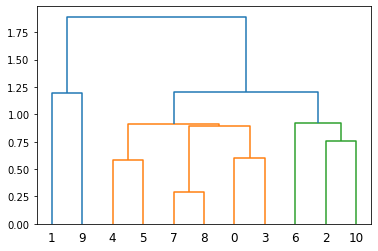

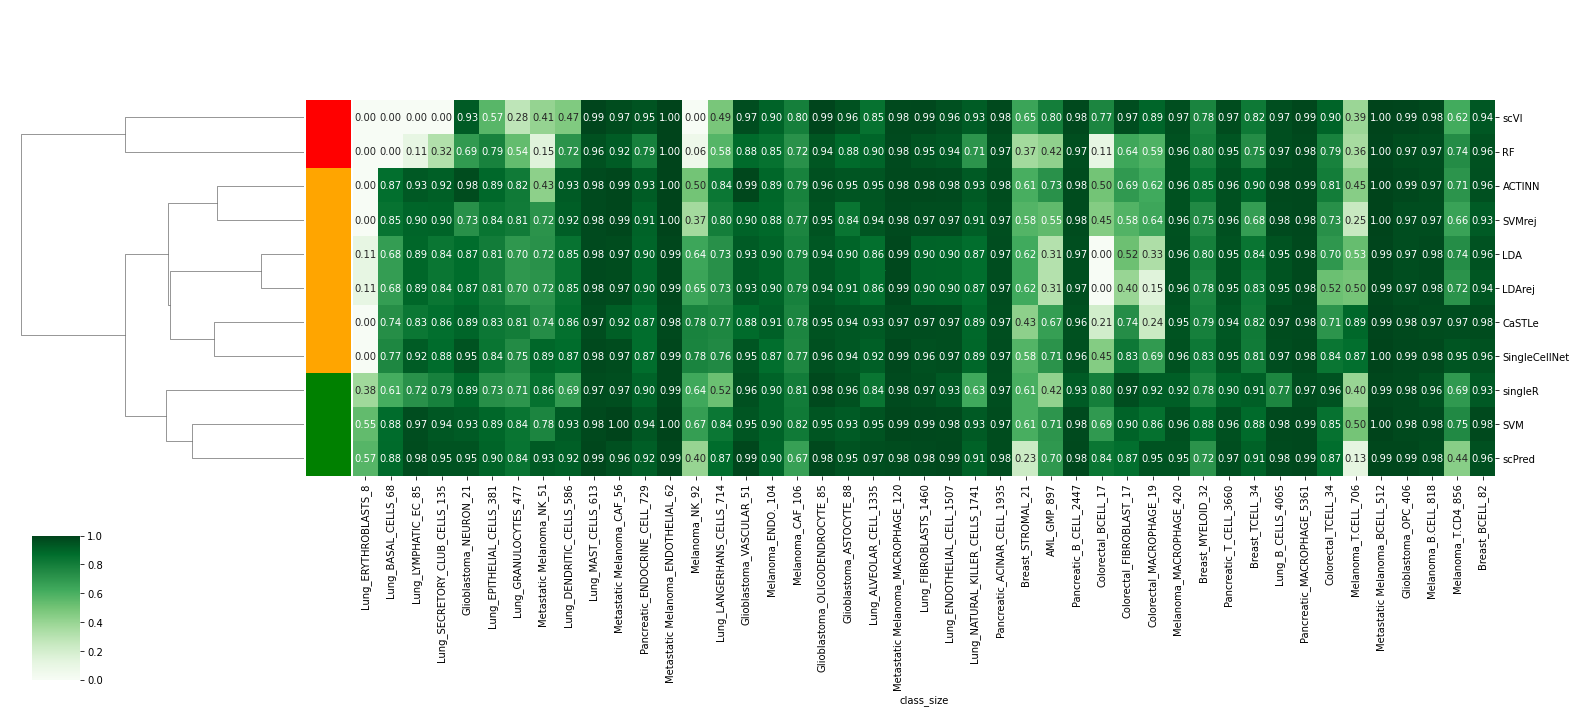

In [3]:
hmdf =  pd.DataFrame()
methods = ['CaSTLe','scVI','SVM','SingleCellNet','ACTINN','SVMrej','singleR','LDA',
           'LDArej','RF','scPred'
          ]
for method in methods:
    tempdf = bigdf[bigdf['method']==method].copy()
    tempdf = tempdf.sort_values(by='proportion')
    tempdf = tempdf[['class_size','f1_score']]
    tempdf = tempdf.rename(columns={'f1_score':method})
    tempdf = tempdf.set_index('class_size')
    hmdf = hmdf.append(tempdf.T,ignore_index=False)
    
    

fig, ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm = sns.heatmap(hmdf,yticklabels=True,xticklabels=True,cmap=colour,annot=True)
hm.set_facecolor('silver')
fig.set_figheight(5)
fig.set_figwidth(25)
plt.close()
        
#Find linkage distances and display a dendrogram
from scipy.cluster.hierarchy import average, fcluster,linkage,dendrogram
for col in hmdf.columns:
    if(hmdf[col].isna().any()):
        hmdf[col]=hmdf[col].fillna(hmdf[col].mean())
z = linkage(hmdf,method='average')
dn = dendrogram(z,color_threshold=0.6*max(z[:,2]))
plt.show()

# get the colors for each algorithm from the dendrogram
    # https://stackoverflow.com/questions/61959602/retrieve-leave-colors-from-scipy-dendrogram
singleton_i = []
points = dn['leaves']
colors = ['none'] * len(points)
for xs, c in zip(dn['icoord'], dn['color_list']):
    for xi in xs:
        if xi % 10 == 5:
            colors[(int(xi)-5) // 10] = c

rows = pd.Series(colors,index=points)
rows = rows.sort_index(axis=0)
# for some reason algorithm 7 is assigned C0, despite being in a different cluster
rows[7] = 'C1'
palette = dict(zip(rows.unique(), ["orange","red","green"]))
row_colors = rows.map(palette).values
cm = sns.clustermap(hmdf,figsize=(22,10),z_score=None,standard_scale=None,
                    row_cluster=True,row_linkage=z,col_cluster=False,
                    cmap=colour,annot=True,row_colors=row_colors,
                    #cbar_pos=(0.02, 0.8, 0.05, 0.18)
                    cbar_pos=(0.02273, .05, .03, .2),fmt=".2f"
                   )
plt.savefig('./plots/rare_cells.png',dpi=500)

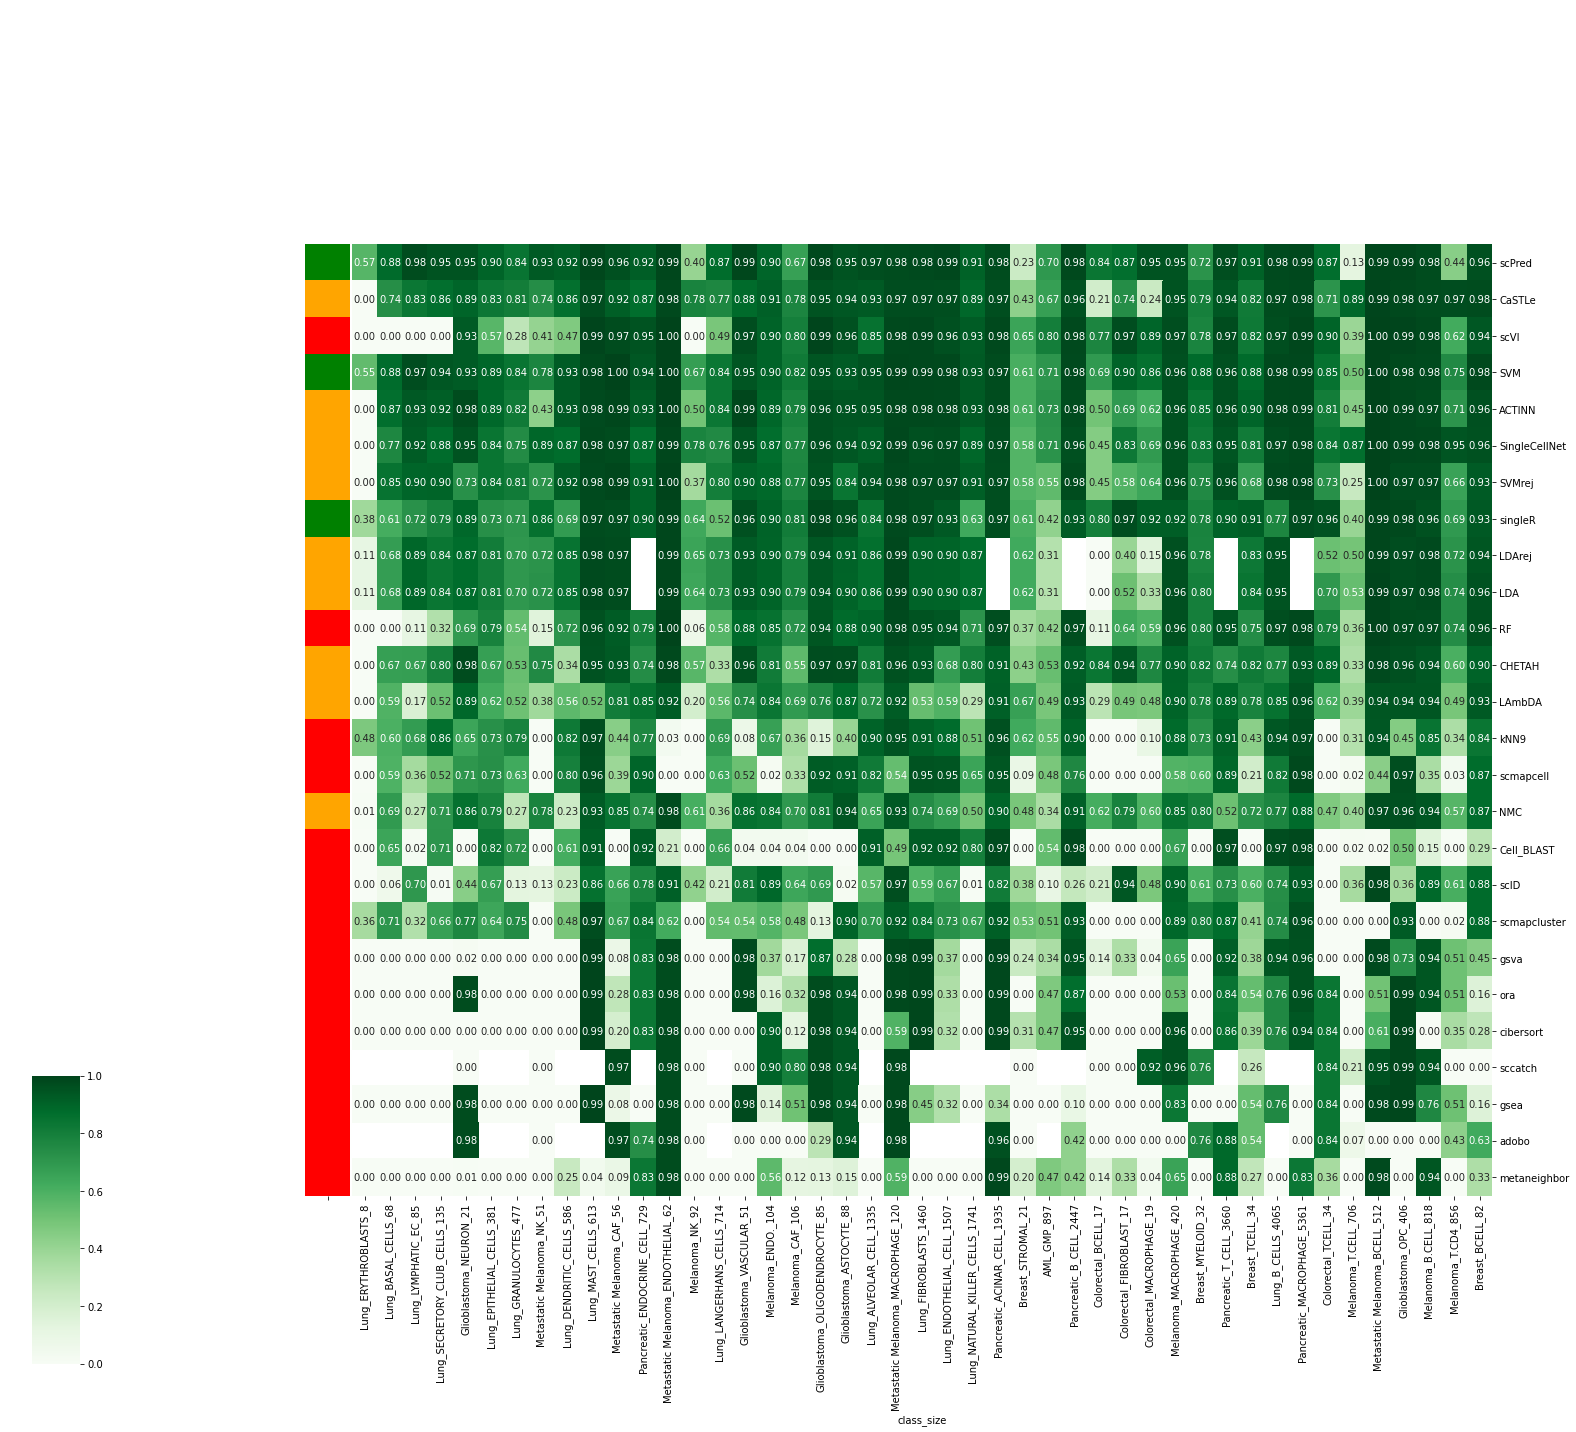

In [4]:
hmdf =  pd.DataFrame()
methods = list(set(bigdf['method']))
methods = ['scPred','CaSTLe','scVI','SVM','ACTINN','SingleCellNet','SVMrej',
           'singleR','LDArej','LDA','RF',
           'CHETAH','LAmbDA','kNN9','scmapcell','NMC','Cell_BLAST','scID',
           'scmapcluster',
           'gsva','ora','cibersort','sccatch','gsea','adobo','metaneighbor'
          ]

#have to set the colours for this one manually
colors = ['1','2','3','1','2','2','2','1','2','2','3',
          '2','2','3','3','2','3','3','3',
          '3','3','3','3','3','3','3']
rows = pd.Series(colors,index=methods)
palette = dict(zip(rows.unique(),["green","orange","red"]))
row_colors = rows.map(palette)
for method in methods:
    tempdf = bigdf[bigdf['method']==method].copy()
    tempdf = tempdf.sort_values(by='proportion')
    tempdf = tempdf[['class_size','f1_score']]
    tempdf = tempdf.rename(columns={'f1_score':method})
    tempdf = tempdf.set_index('class_size')
    hmdf = hmdf.append(tempdf.T,ignore_index=False)
    
    

fig, ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm = sns.heatmap(hmdf,yticklabels=True,xticklabels=True,cmap=colour,annot=True)
hm.set_facecolor('silver')
fig.set_figheight(18)
fig.set_figwidth(25)
plt.close()
cm = sns.clustermap(hmdf,figsize=(22,20),z_score=None,standard_scale=None,
                    row_cluster=False,col_cluster=False,cmap=colour,annot=True,
                    fmt=".2f",row_colors=row_colors,cbar_pos=(0.02273,.05,.03,.2),
                    facecolor='silver'
                   )
plt.savefig('./supplemental/rare_cells_all_methods.png',dpi=500)
plt.show()